## Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
# from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import json
from torch.nn.utils.rnn import pad_sequence
import random 
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import copy

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use your GPU.")
else:
    print("CUDA is not available. PyTorch will run on CPU.")

CUDA is available. PyTorch can use your GPU.


## Dataset Class for Dataloader

In [3]:
class TrajectoryDataset(Dataset):

    def __init__(self, json_file):

        with open(json_file, 'r') as f:
            self.data_dict = json.load(f)
        
        self.data = self.data_dict['data']
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        item = self.data[idx]
        
        goal = np.array([
            item['config']['goal']['x'],
            item['config']['goal']['y'],
            item['config']['goal']['z']
        ])
        
        config = goal # Label, Shape (3, )
        
        waypoints = []
        for wp in item['trajectory']['waypoints']:
            waypoints.append([
                wp['x'], wp['y'], wp['z'],
                wp['qx'], wp['qy'], wp['qz'], wp['qw']
            ])
        trajectory = np.array(waypoints)  # Output Data, Shape: (seq_len, 7)
        
        return torch.FloatTensor(config), torch.FloatTensor(trajectory)
    

# from diffusion_policy.diffusion_policy.model.diffusion.conv1d_components import Downsample1d

# num_downsamples = sum(
#     1
#     for m in model.modules()
#     if isinstance(m, Downsample1d)
# )

# print("NUM_DOWNSAMPLES:", num_downsamples)
# BASE = 2 ** num_downsamples
# print("BASE:", BASE)
    
NUM_DOWNSAMPLES = 2              # adjust if you change the UNet arch
BASE = 2 ** NUM_DOWNSAMPLES      # e.g. 4

def collate_pad(batch):
    xs, ys = zip(*batch)                 # xs: list of (3,), ys: list of (L_i, 2)
    xs = torch.stack(xs, dim=0)          # (B, 3)

    lengths = torch.tensor([y.size(0) for y in ys], dtype=torch.long)

    # First, pad to batch max using pad_sequence
    ys = pad_sequence(ys, batch_first=True)   # (B, T_max, 2)
    B, T_max, D = ys.shape

    # Compute the "good" length for this batch: nearest multiple of BASE ≥ T_max
    T_good = int(math.ceil(T_max / BASE) * BASE)

    if T_good > T_max:
        # Allocate a new tensor with the larger temporal dimension
        ys_padded = torch.zeros(B, T_good, D, dtype=ys.dtype)
        ys_padded[:, :T_max, :] = ys

        # Build mask with the new length
        mask = torch.zeros(B, T_good, dtype=torch.bool)
        for b, L in enumerate(lengths):
            mask[b, :L] = True

        ys = ys_padded
    else:
        # T_max was already a multiple of BASE
        mask = torch.zeros(B, T_max, dtype=torch.bool)
        for b, L in enumerate(lengths):
            mask[b, :L] = True

    return xs, ys, lengths, mask

## Training Loop

In [4]:
def train(model, noise_scheduler, train_loader, val_loader, 
          lr_scheduler, ema, optimizer, epochs, 
          device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    model = model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
    }

    for epoch in range(epochs):

        model.train()
        training_loss = 0.0

        for i, batch in enumerate(train_loader):

            goal = batch[0].to(device)        # (B, 3)
            gt_traj = batch[1].to(device)     # (B, T_max, 7)
            gt_lengths = batch[2].to(device)
            gt_mask = batch[3].to(device)

            batch_size, max_traj_len, _ = gt_traj.shape
            gt_traj_xy = gt_traj[:, :, :2]  # (B, T, 2) - just x, y

            optimizer.zero_grad()

            # Sample noise 
            noise = torch.randn(gt_traj_xy.shape, device=device)

            # sample a diffusion iteration for each data point
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (batch_size,), device=device
            ).long()

            # Forward Diffusion Process (Add Noise to Trajectory)
            noisy_traj = noise_scheduler.add_noise(gt_traj_xy, noise, timesteps)

            # predict the noise residual
            noise_pred = model(noisy_traj, timesteps, global_cond=goal)

            # L2 loss
            loss = nn.functional.mse_loss(noise_pred, noise, reduction='none')
            loss = loss.mean(-1)
            loss = ((loss * gt_mask).sum())/(gt_mask.sum())

            # optimize
            loss.backward()
            optimizer.step()

            # step lr scheduler every batch
            # this is different from standard pytorch behavior
            lr_scheduler.step()

            # update Exponential Moving Average of the model weights
            ema.step(model.parameters())

            training_loss += loss.item()

            # ------------------------------------------------------------------
            # Debug print every 20 epochs on the first batch: generate a traj
            # via diffusion (as in testing) and compare to GT, step-by-step.
            # ------------------------------------------------------------------
            if (epoch + 1) % 20 == 0 and i == 0:
                # build an EMA-weighted copy of the model for sampling
                ema_model = copy.deepcopy(model).to(device)
                ema.copy_to(ema_model.parameters())
                ema_model.eval()

                T_pred = max_traj_len   # use same padded length as this batch

                # set inference timesteps (you can choose a smaller number later)
                num_inference_steps = 100
                noise_scheduler.set_timesteps(num_inference_steps)

                with torch.no_grad():
                    # start from Gaussian noise
                    traj = torch.randn(batch_size, T_pred, 2, device=device)

                    # reverse diffusion loop
                    for t_step in noise_scheduler.timesteps:
                        noise_pred_infer = ema_model(
                            sample=traj,          # (B, T_pred, 2)
                            timestep=t_step,      # scalar or tensor
                            global_cond=goal      # (B, 3)
                        )
                        traj = noise_scheduler.step(
                            model_output=noise_pred_infer,
                            timestep=t_step,
                            sample=traj
                        ).prev_sample

                    pred_traj_xy = traj  # (B, T_pred, 2)

                    # ---- Pretty print: pred vs GT per timestep ----
                    print("\n=== Diffusion Translation Predictions vs Ground Truth ===")
                    for b in range(batch_size):
                        valid_length = int(gt_lengths[b].item())
                        if valid_length <= 0:
                            continue

                        print(f"\nTrajectory {b} (length={valid_length}):")
                        print("Step |  Pred (x, y)    |   GT (x, y)     |  Error")
                        print("-" * 55)

                        for t_idx in range(valid_length):
                            pred_x = pred_traj_xy[b, t_idx, 0].item()
                            pred_y = pred_traj_xy[b, t_idx, 1].item()
                            gt_x   = gt_traj_xy[b, t_idx, 0].item()
                            gt_y   = gt_traj_xy[b, t_idx, 1].item()

                            err = (pred_x - gt_x)**2 + (pred_y - gt_y)**2
                            print(f"{t_idx:4d} | ({pred_x:6.3f}, {pred_y:6.3f}) | "
                                  f"({gt_x:6.3f}, {gt_y:6.3f}) | {err:6.4f}")
                # back to training mode for rest of the epoch
                model.train()
            # ------------------------------------------------------------------

        average_train_loss = training_loss / len(train_loader)
        history['train_loss'].append(average_train_loss)

        # ========= VALIDATION =========
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for i, batch in enumerate(val_loader):

                goal = batch[0].to(device)        # (B, 3)
                gt_traj = batch[1].to(device)        # (B, T_max, 7)
                gt_lengths = batch[2].to(device)
                gt_mask = batch[3].to(device).float()   # (B, T_max)

                batch_size, max_traj_len, _ = gt_traj.shape
                gt_traj_xy = gt_traj[:, :, :2]  # (B, T, 2)

                # Sample noise
                noise = torch.randn(gt_traj_xy.shape, device=device)

                # Sample diffusion timestep
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (batch_size,), device=device
                ).long()

                # Forward diffusion (add noise)
                noisy_traj = noise_scheduler.add_noise(gt_traj_xy, noise, timesteps)

                # Predict noise
                noise_pred = model(noisy_traj, timesteps, global_cond=goal)

                # Masked L2 loss, same as train but no backward/opt
                val_batch_loss = nn.functional.mse_loss(
                    noise_pred, noise, reduction='none'
                )                        # (B, T, 2)
                val_batch_loss = val_batch_loss.mean(-1)   # (B, T)
                val_batch_loss = (val_batch_loss * gt_mask).sum() / gt_mask.sum()

                val_loss += val_batch_loss.item()

        average_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(average_val_loss)


        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss = {average_train_loss:.4f}, "
              f"Val Loss = {average_val_loss:.4f}")
        
    return history

## Conditional 1-D U-Net Architecture as the Noise Prediction Network

The below diffusion model architecture is from the [github repo](https://github.com/real-stanford/diffusion_policy) of the 2023 RSS paper Diffusion Policy: Visuomotor Policy Learning via Action Diffusion

In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


## Initialize Training and Validation Sets

In [6]:
dataset = TrajectoryDataset('datasets/goal_input_only_datasets/train/dataset_multi_obs.json')

N = len(dataset)
train_size = int(0.8 * N)
val_size = N-train_size

train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size],
)

train_dataloader = DataLoader(
    train_dataset,  
    batch_size=8,
    collate_fn=collate_pad,
    shuffle=True,
    num_workers=0  
)
        
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=8,
    collate_fn=collate_pad,
    shuffle=False,
    num_workers=0
)


lengths = [len(item['trajectory']['waypoints']) for item in dataset.data]
print(f"Dataset Length: {N}")
print(f"Length statistics: Mean={np.mean(lengths):.1f}, Std={np.std(lengths):.1f}")
print(f"Min={np.min(lengths)}, Max={np.max(lengths)}")
print(f"Histogram: {np.histogram(lengths, bins=10)}")

Dataset Length: 320
Length statistics: Mean=73.1, Std=19.9
Min=57, Max=134
Histogram: (array([140, 110,  14,   1,   7,  12,   4,   1,  19,  12]), array([ 57. ,  64.7,  72.4,  80.1,  87.8,  95.5, 103.2, 110.9, 118.6,
       126.3, 134. ]))


## Initialize Diffusion Model, Noise Scheduler, Optimizer, and other components to improve training. 

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
state_dim = 2
goal_dim = 3
EPOCHS = 600

model = ConditionalUnet1D(
    input_dim=state_dim,
    global_cond_dim=goal_dim
)
model = model.to(device)

num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    beta_schedule='squaredcos_cap_v2',
    clip_sample=False,
    prediction_type='epsilon'
)

# Note that EMA parameters are not optimized
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=model.parameters(),
    power=0.75)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader)*EPOCHS
)

number of parameters: 6.525287e+07


## Train

In [ ]:
history = train(model=model, noise_scheduler=noise_scheduler, train_loader=train_dataloader, val_loader=val_dataloader, 
                lr_scheduler=lr_scheduler, ema=ema, optimizer=optimizer, epochs=EPOCHS)

## Test: Visualize Generated Trajectories

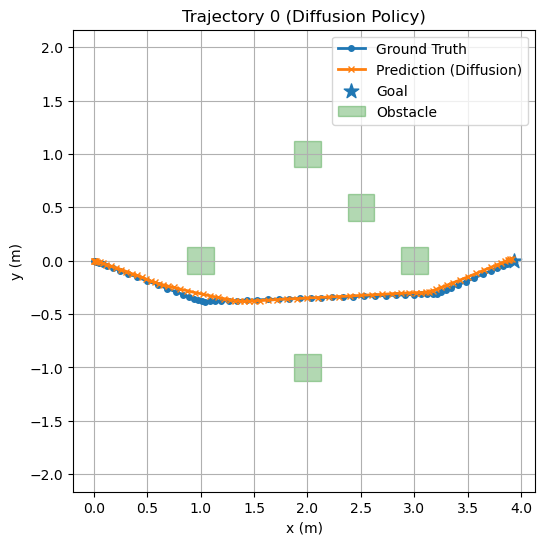

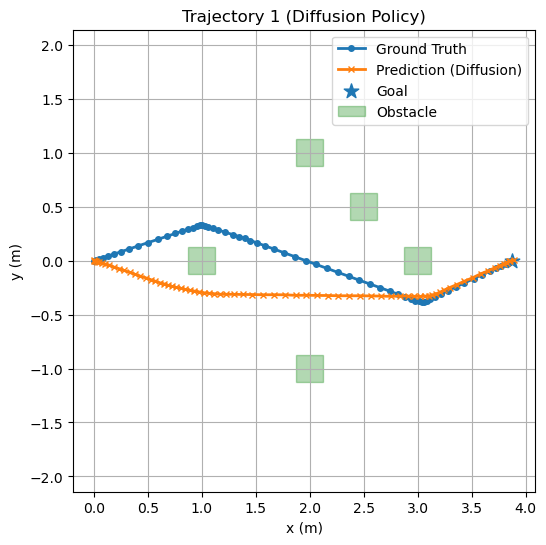

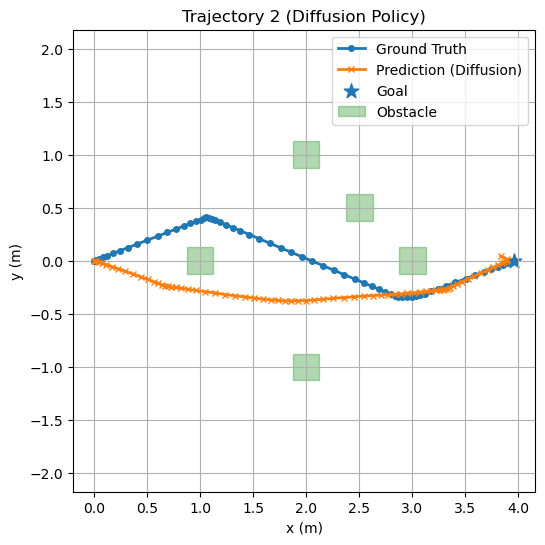

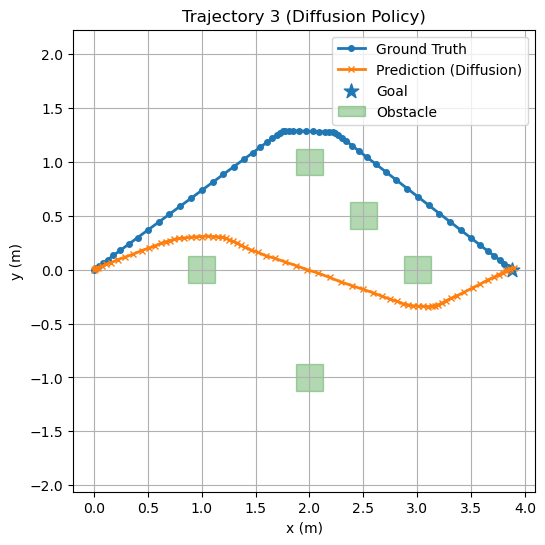

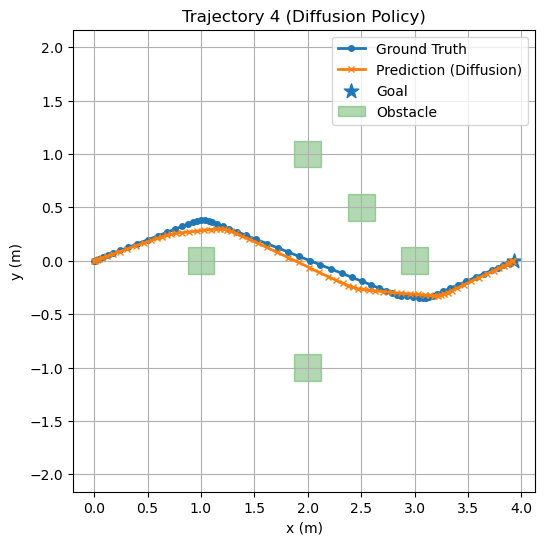

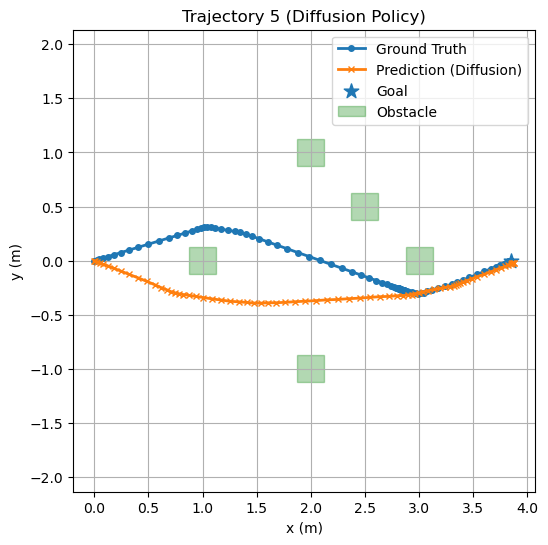

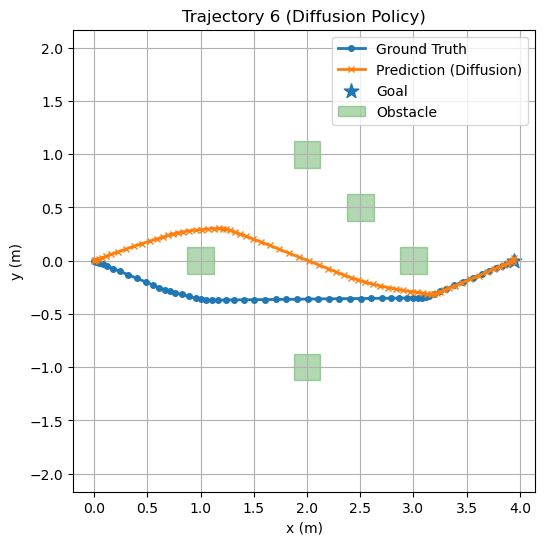

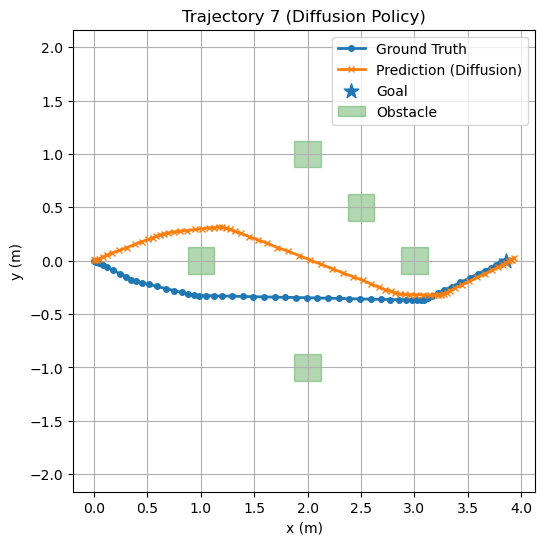

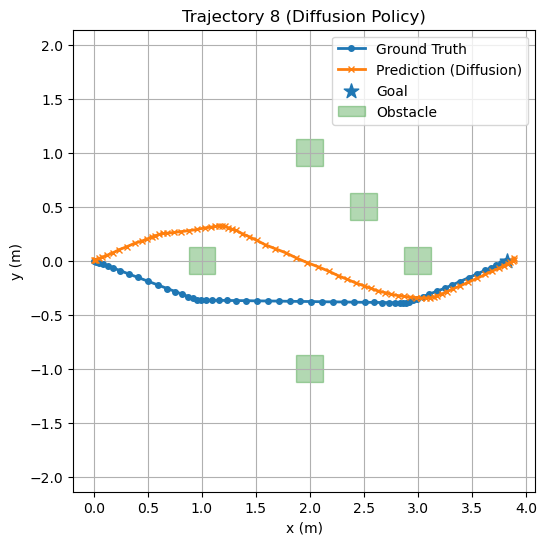

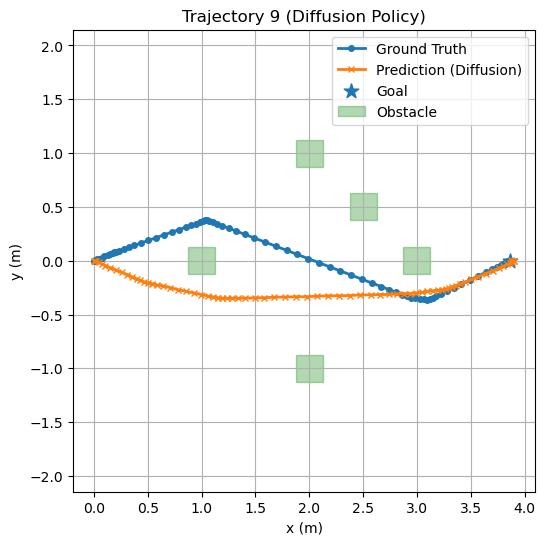

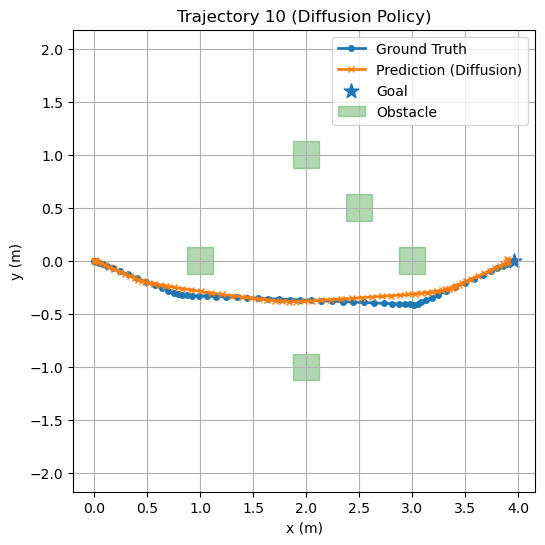

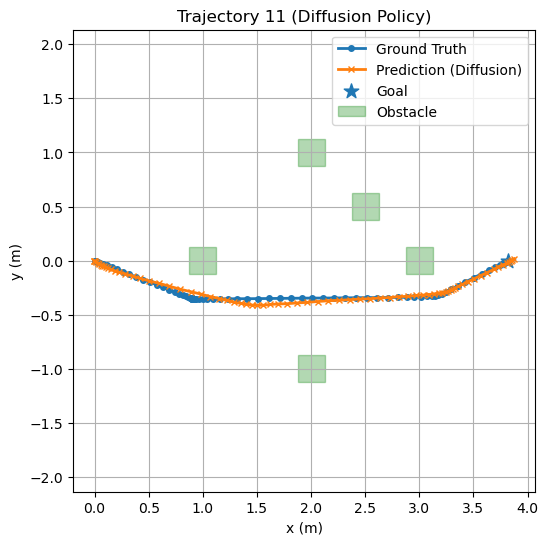

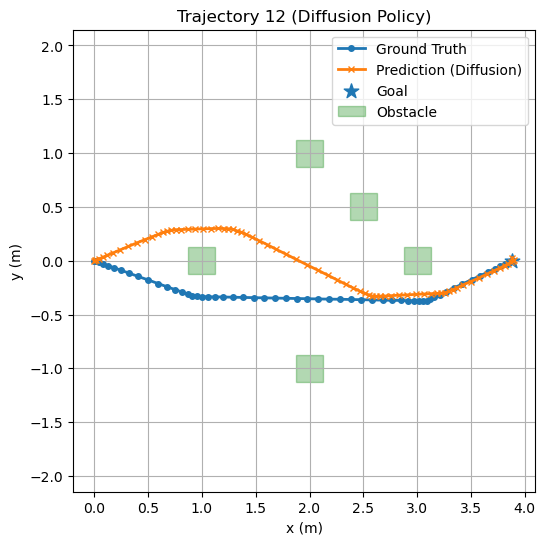

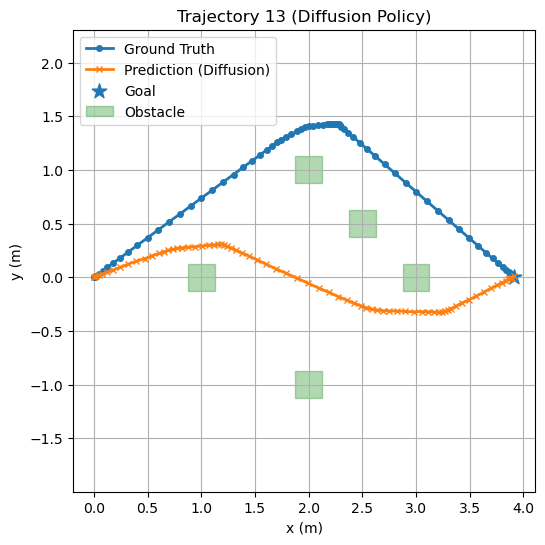

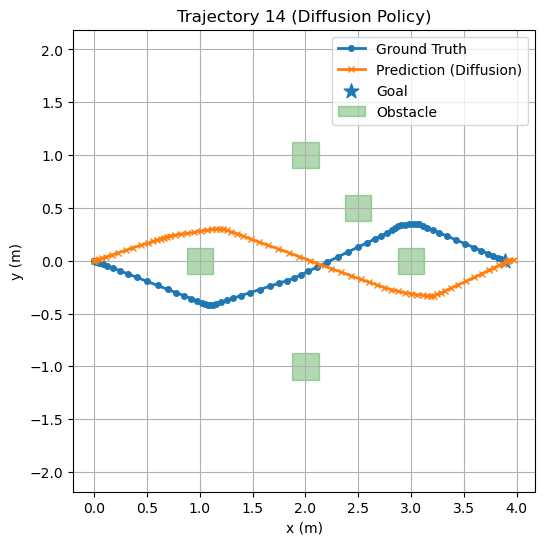

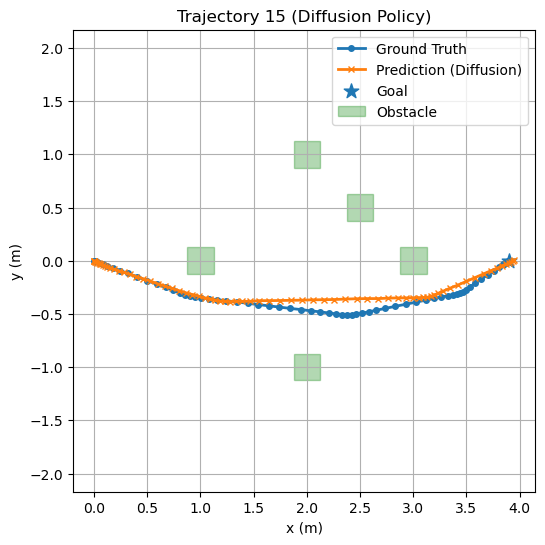

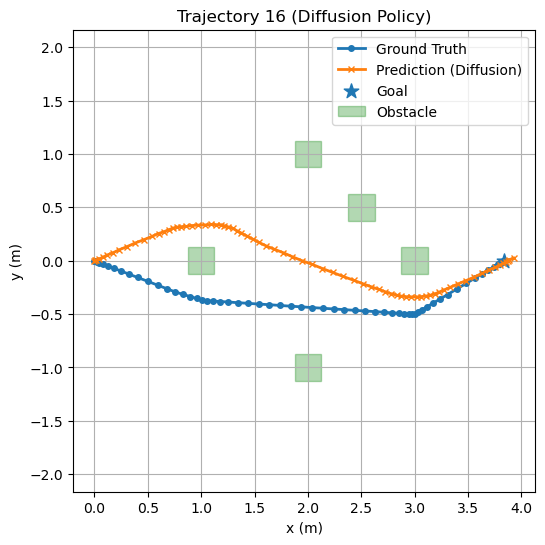

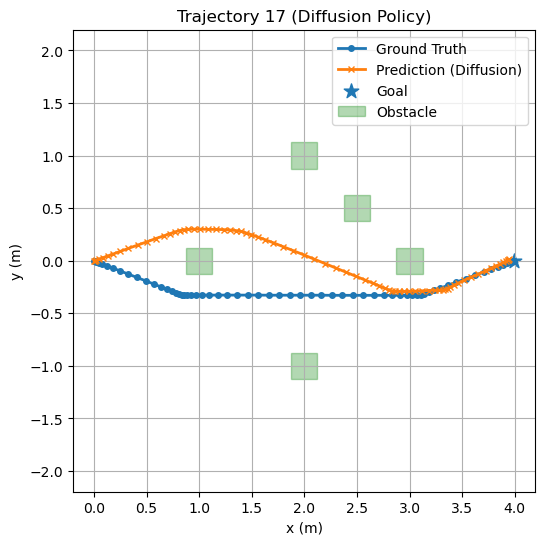

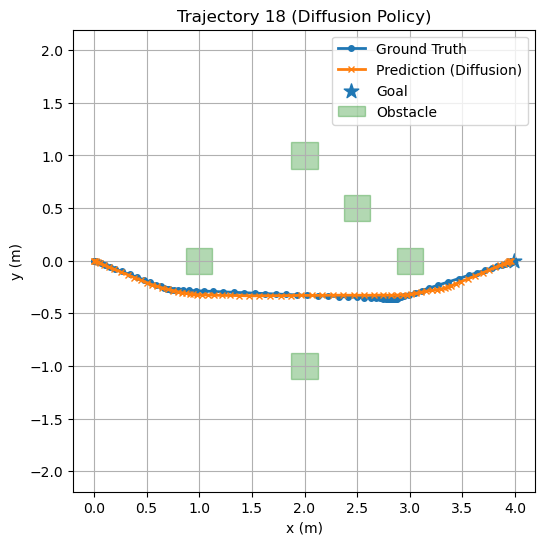

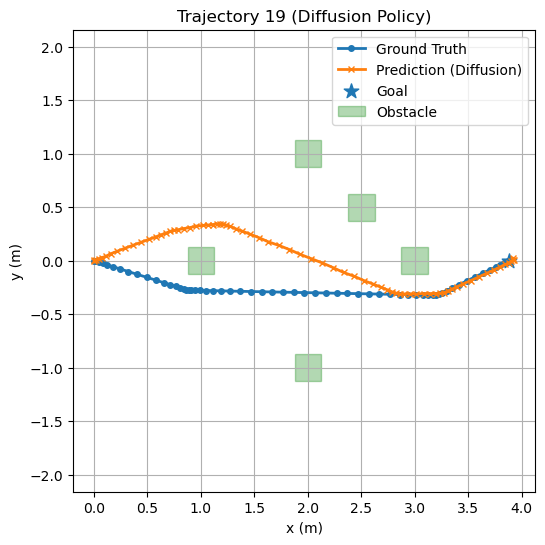

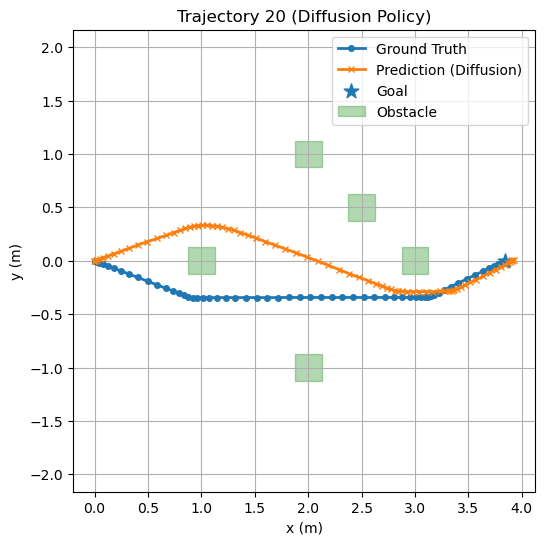

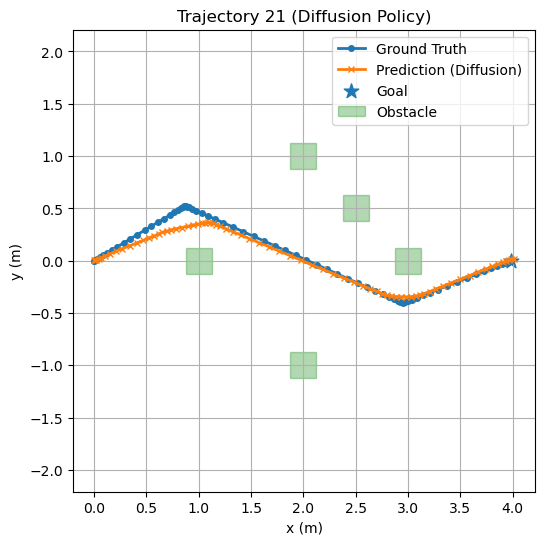

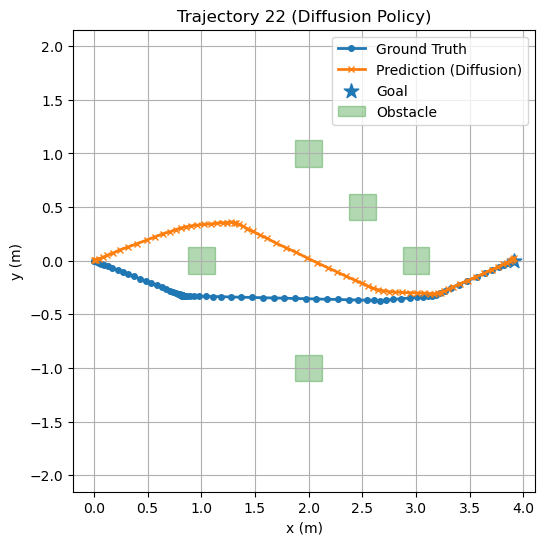

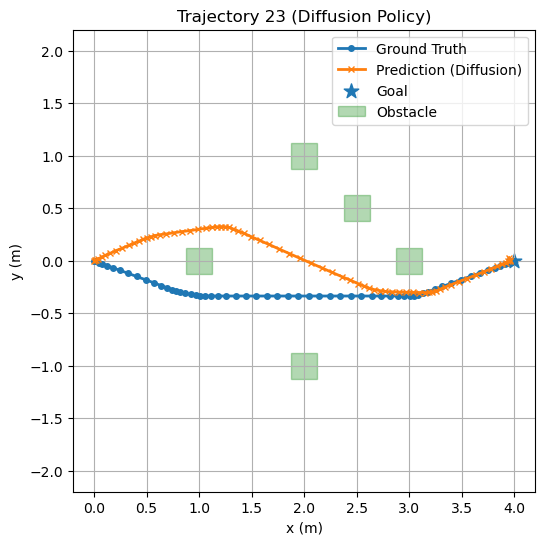

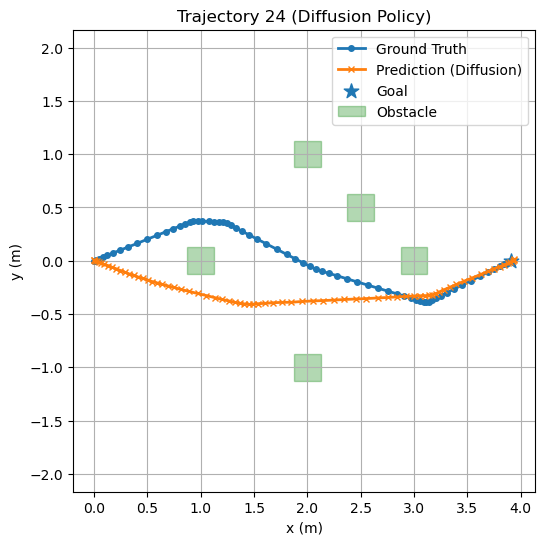

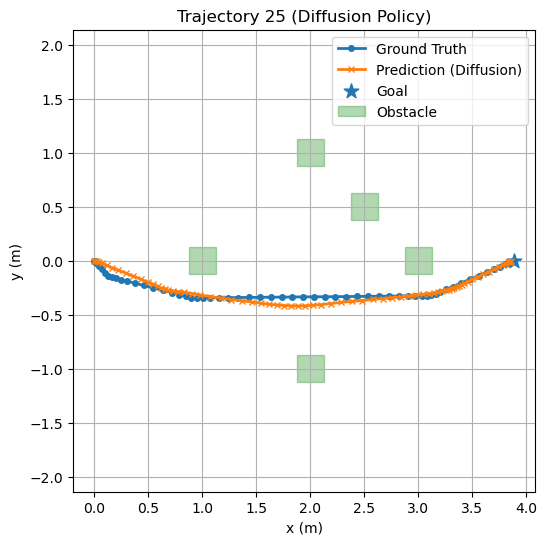

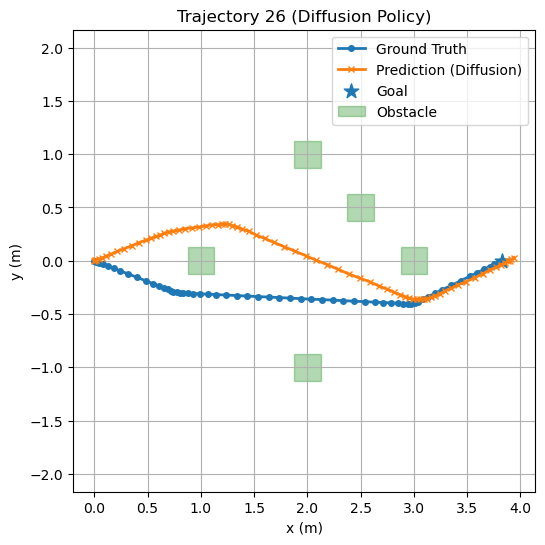

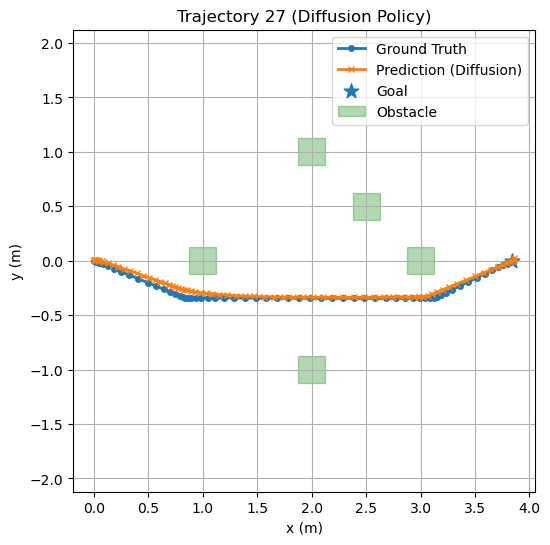

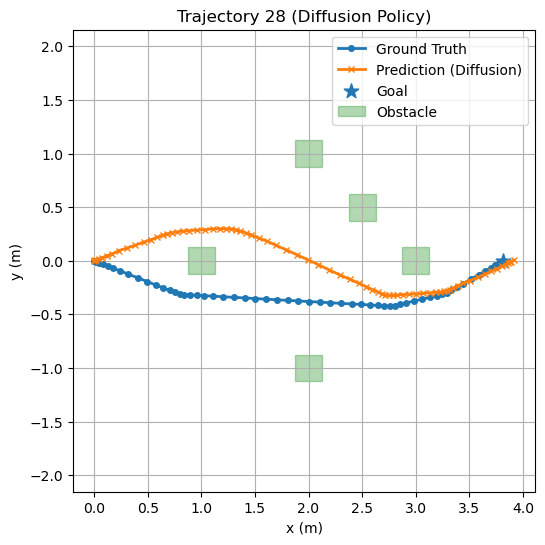

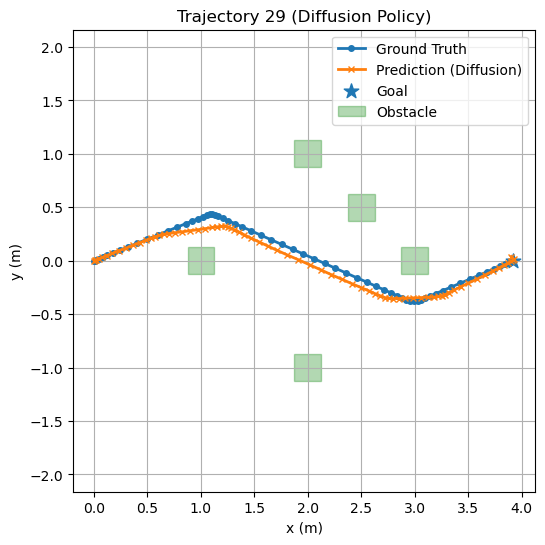

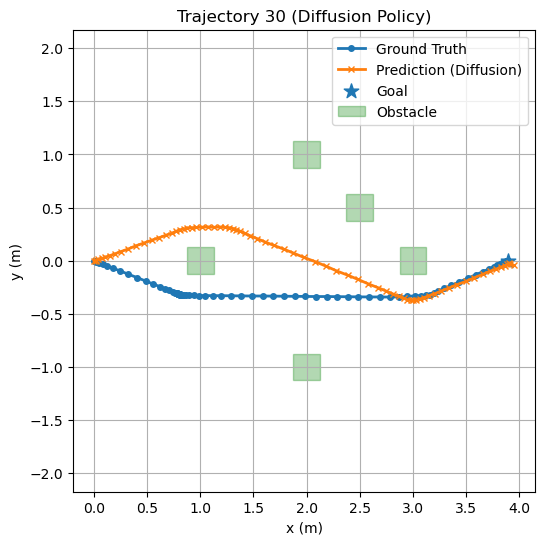

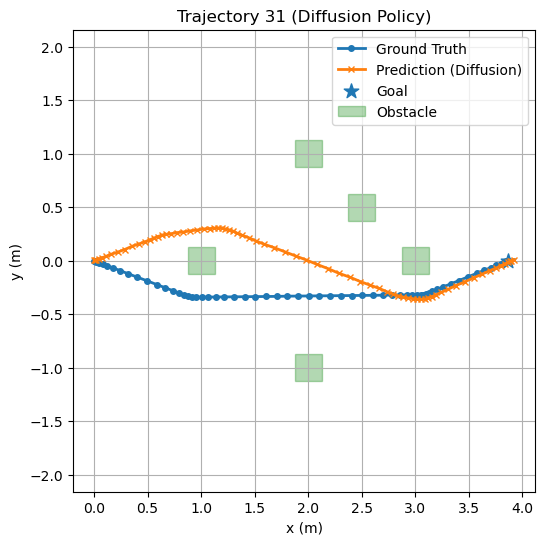

In [9]:
def test(
    model,
    noise_scheduler,
    test_loader,
    num_inference_steps,
    T_pred,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    model:   diffusion model with EMA weights applied (nn.Module)
    noise_scheduler: DDPMScheduler used for training
    test_loader: DataLoader over test TrajectoryDataset
    T_pred:      number of timesteps to predict (trajectory length)
    num_inference_steps: number of denoising steps; if None, use full training steps
    """

    model.to(device)
    model.eval()

    # # If not specified, use the full training schedule
    # if num_inference_steps is None:
    #     num_inference_steps = noise_scheduler.config.num_train_timesteps

    # # Set up inference timesteps
    # noise_scheduler.set_timesteps(num_inference_steps)

    with torch.no_grad():
        for i, batch in enumerate(test_loader):

            # batch assumed to be (goal, traj, lengths, mask) or similar
            goal = batch[0].to(device)       # (B, 3)
            gt_traj = batch[1].to(device)       # (B, T_gt_max, 7)
            gt_lengths = batch[2].to(device)      # (B,)

            batch_size, _, _ = gt_traj.shape
            assert batch_size == 1, "This plotting code assumes batch_size == 1"

            # ----- Ground-truth x,y trajectory -----
            gt_translation = gt_traj[:, :, :2]    # (B, T_gt_max, 2)
            gt_L = int(gt_lengths[0].item())
            gt_xy = gt_translation[0, :gt_L, :].detach().cpu().numpy()  # (T_gt, 2)

            # ----- Conditioning (goal) -----
            goal_xy = goal[0, :2].detach().cpu().numpy()                # (2,)

            # ----- Sample trajectory from diffusion model -----
            # Initialize from Gaussian noise (B, T_pred, 2)
            traj = torch.randn(batch_size, T_pred, 2, device=device)

            noise_scheduler.set_timesteps(num_inference_steps)

            for t in noise_scheduler.timesteps:
                # Predict noise 
                noise_pred = model(
                    sample=traj,        # (B, T_pred, 2)
                    timestep=t,         # current diffusion step
                    global_cond=goal  # (B, 3)
                )

                # inverse diffusion step (remove noise)
                traj = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=t,
                    sample=traj
                ).prev_sample

            # traj is now the predicted (x,y) trajectory of length T_pred, in the same units as gt_traj
            pred_xy = traj.detach().to('cpu').numpy()  # (T_pred, 2)
            pred_xy = pred_xy[0]

            # ----- Plot Prediction and Ground Truth trajectories on (x,y) grid -----
            fig, ax = plt.subplots(figsize=(6, 6))

            # Ground-truth trajectory
            ax.plot(
                gt_xy[:, 0], gt_xy[:, 1],
                '-o', linewidth=2, markersize=4, label='Ground Truth'
            )

            # Predicted trajectory
            ax.plot(
                pred_xy[:, 0], pred_xy[:, 1],
                '-x', linewidth=2, markersize=4, label='Prediction (Diffusion)'
            )

            # Mark the goal position
            ax.scatter(
                goal_xy[0], goal_xy[1],
                marker='*', s=120, label='Goal'
            )

            # ---- Draw 5 obstacles as green squares ----
            obstacle_centers = [
                (2.0, -1.0),
                (1.0, 0.0),
                (2.0, 1.0),
                (2.5, 0.5),
                (3.0, 0.0)
            ]
            side = 0.25
            
            # Lists to store obstacle bounds for axis limit calculation
            obstacle_x_bounds = []
            obstacle_y_bounds = []
            
            for idx, obstacle_center in enumerate(obstacle_centers):
                lower_left = (obstacle_center[0] - side/2, obstacle_center[1] - side/2)

                obstacle_patch = Rectangle(
                    lower_left,
                    side, side,
                    facecolor='green',
                    alpha=0.3,
                    edgecolor='green',
                    label='Obstacle' if idx == 0 else None  # Only label the first obstacle
                )
                ax.add_patch(obstacle_patch)
                
                # Store bounds for axis limits
                obstacle_x_bounds.extend([obstacle_center[0] - side/2, obstacle_center[0] + side/2])
                obstacle_y_bounds.extend([obstacle_center[1] - side/2, obstacle_center[1] + side/2])
            # ----------------------------------------

            ax.set_xlabel('x (m)')
            ax.set_ylabel('y (m)')
            ax.set_title(f'Trajectory {i} (Diffusion Policy)')
            ax.grid(True)

            # --- Make x and y axis have the same numeric span (square view) ---

            all_x = np.concatenate([
                gt_xy[:, 0],
                pred_xy[:, 0],
                np.array([goal_xy[0]]),
                np.array(obstacle_x_bounds)
            ])
            all_y = np.concatenate([
                gt_xy[:, 1],
                pred_xy[:, 1],
                np.array([goal_xy[1]]),
                np.array(obstacle_y_bounds)
            ])

            x_min, x_max = all_x.min(), all_x.max()
            y_min, y_max = all_y.min(), all_y.max()

            x_range = x_max - x_min
            y_range = y_max - y_min
            max_range = max(x_range, y_range)

            x_mid = 0.5 * (x_min + x_max)
            y_mid = 0.5 * (y_min + y_max)

            margin = 0.1 * max_range
            half = 0.5 * (max_range + margin)

            ax.set_xlim(x_mid - half, x_mid + half)
            ax.set_ylim(y_mid - half, y_mid + half)

            ax.set_aspect('equal', adjustable='box')
            # ---------------------------------------------------------------

            ax.legend()
            plt.show()

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = model
ema.copy_to(ema_noise_pred_net.parameters())

test_dataset = TrajectoryDataset('datasets/goal_input_only_datasets/test/dataset_multi_obs_test.json')

test_dataloader = DataLoader(
    test_dataset,  
    collate_fn=collate_pad,
    shuffle=False,
    num_workers=0  
)

test(ema_noise_pred_net, noise_scheduler, test_dataloader, num_inference_steps=20, T_pred=72)